## Unsupervised machine learning
In this notebook we will continue working on the data and attempt to classify areas through unsupervised machine learning. We  will preprocess the data, conduct a principle component analysis and we will use a K-means classifier to produce a classification result. The K-means method is used since we have no ground truth information available. Since there is an abundance of information available on K-means I will not dive into details here.

In [1]:
from glob import glob
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Load images that has already been sliced and diced in SNAP toolbox

path = '../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger/'

s2_bands = glob(path+'*B*.tif')
s2_bands.sort()

print('Showing all loaded bands, the order they are loaded in and array identifier:')
for ix, ls in enumerate(s2_bands):
    print(ls + f', Array ID [{ix}]')

# Load all bands and stack them in a np array
img = []

for i in s2_bands:
    #print(i)
    with rasterio.open(i, 'r') as f:
        img.append(f.read(1))
        
arr_st = np.stack(img)

Showing all loaded bands, the order they are loaded in and array identifier:
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B01.tif, Array ID [0]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B02.tif, Array ID [1]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B03.tif, Array ID [2]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B04.tif, Array ID [3]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B05.tif, Array ID [4]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B06.tif, Array ID [5]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B07.tif, Array ID [6]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B08.tif, Array ID [7]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger\subset_resampled_B09.tif, 

With the data loaded in, we can begin a few reshaping operations to preprocess the data

In [3]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

x.reshape(-1, 13).shape, 5718*5124

((29299032, 13), 29299032)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_data = x.reshape(-1, 13)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(29299032, 13)

The data is new reshaped and the features are standardized by removing the mean and scaling to unit variance.

### Principal component analysis
We now use a PCA  by reducing the dimensionality of the data whilst preserving as much of the infomation contained in the data as possible. 

In [5]:
pca = PCA(n_components = 6)

pca.fit(X_scaled)

data = pca.transform(X_scaled)
data.shape

(29299032, 6)

In [6]:
pca.explained_variance_ratio_

array([0.68038934, 0.19773456, 0.04230004, 0.03513808, 0.02218026,
       0.01175771])

In [7]:
np.sum(pca.explained_variance_ratio_)

0.9894999923283014

### PCA visualisation of 6 components
Looking at the explained variance ratio and the below 6 plotted components, we see that there is really no reason to go above 3-4 components in this. The 6 components account for a sum of 0.9894.

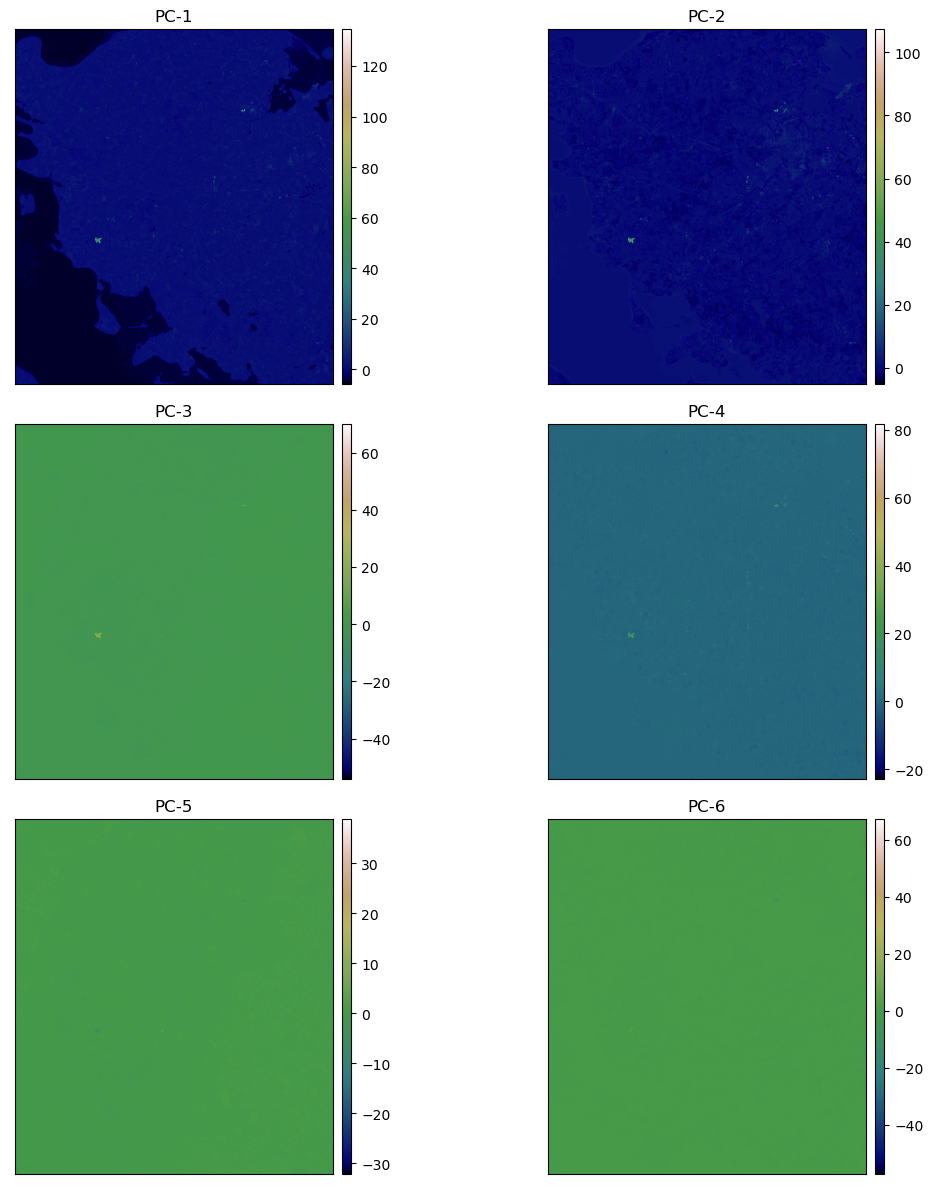

In [8]:
ep.plot_bands(np.moveaxis(data.reshape((5718, 5124, data.shape[1])), -1, 0),
    cmap = 'gist_earth',
    cols = 2,
    title = [f'PC-{i}' for i in range(1,7)])
plt.show()


### Calculating Within Cluster Sum of Squares (WCSS)
By using the WCSS method and plotting the "elbow" plot, we can derive what the optimal clustering value is. Read more here: [External link](https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/) 

In [16]:
wcss = [] 
for number_of_clusters in range(1, 6):
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(data) 
    wcss.append(kmeans.inertia_)
wcss

[376888095.20994604,
 163168966.2160485,
 123326049.74935862,
 95001846.75120066,
 79463812.194555]

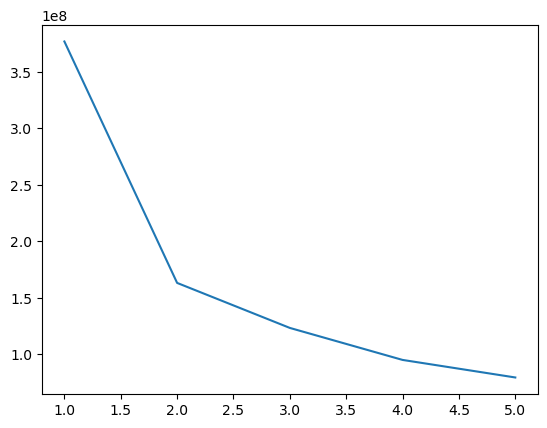

In [17]:
ks = list(range(1,6))
plt.plot(ks, wcss)

Using the elbow method to discern a good n_clusters value.

### Using K-means with 6 clusters

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, random_state = 42, init="k-means++")

kmeans.fit(data)

KMeans(n_clusters=6, random_state=42)

In [11]:
labels = kmeans.predict(data)
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

### Visualize clusters

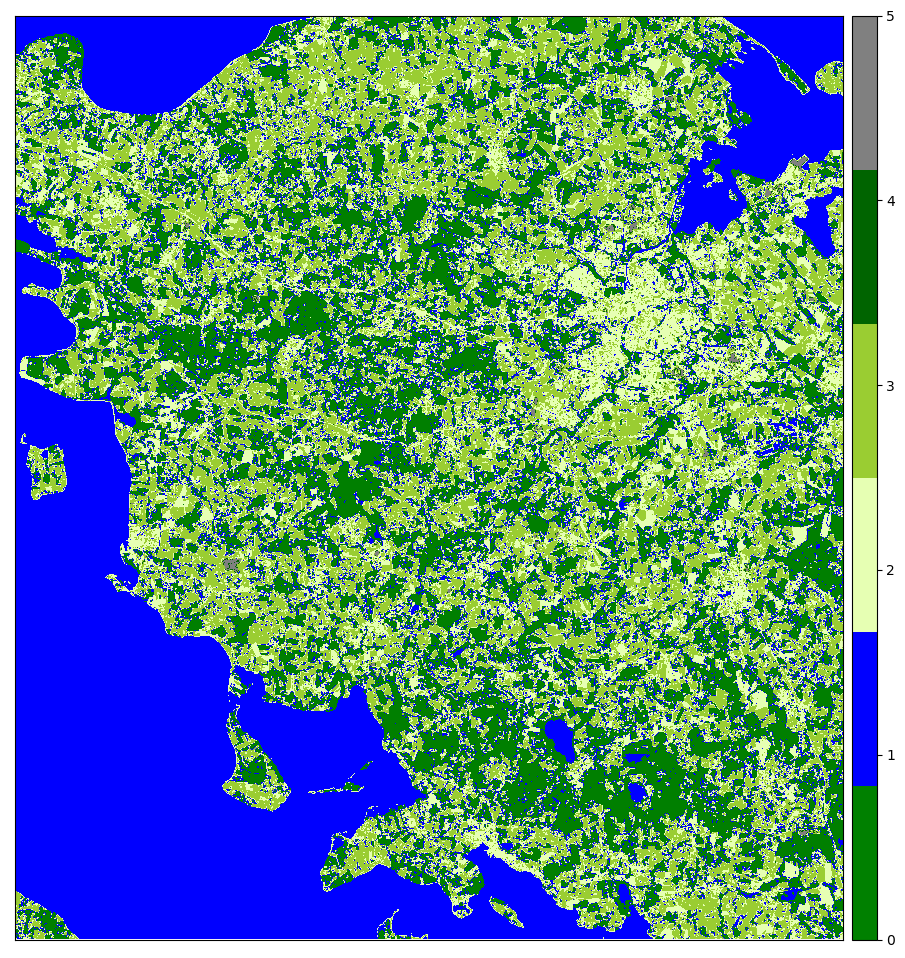

In [12]:
ep.plot_bands(labels.reshape(5718, 5124), cmap=ListedColormap(['g', 'blue', '#e6ffb3', 'yellowgreen', 'darkgreen', 'gray']))#['#ffcc33', '#008000', 'navy', 'gray', 'black', 'darkgreen']))
plt.show()

In [13]:
# Generating "ground truth" map off the NDVI parameters
ndvi = ( (arr_st[7]-arr_st[3])/(arr_st[7]+arr_st[3]) )
ndvi_class_bins = [-np.inf, 0, 0.15, 0.25, 0.4, 0.6, 1.0, np.inf]
ndvi_sent_class = np.digitize(ndvi, ndvi_class_bins)
ndvi_sent_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_sent_class
)
np.unique(ndvi_sent_class)

# Define color map
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen", 'blue']
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Class 0 - No Vegetation",
    "Class 1 - Bare Area",
    "Class 2 - Low Vegetation",
    "Class 3 - Moderate Vegetation",
    "Class 4 - Dense Vegetation",
    "Class 5 - Water",
]

# Get list of classes
classes = np.unique(ndvi_sent_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:6]

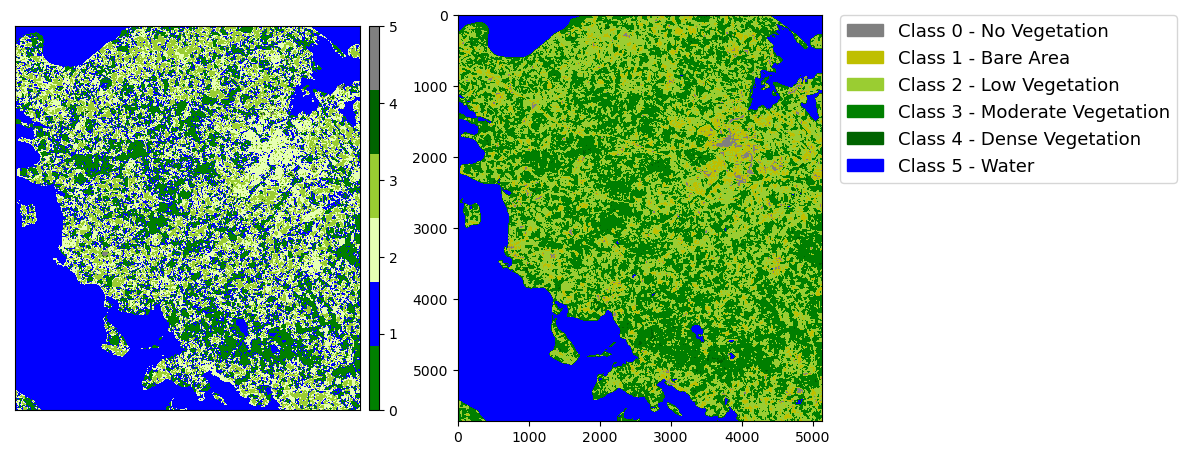

In [14]:
## Plotting the two side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 12))
ndvi[ndvi > 1] = -1 #For better seing water
ax1 = ep.plot_bands(labels.reshape(5718, 5124), cmap=ListedColormap(['g', 'blue', '#e6ffb3', 'yellowgreen', 'darkgreen', 'gray']), ax=ax1)
ax2 = ax2.imshow(ndvi_sent_class, cmap=nbr_cmap)
ep.draw_legend(im_ax=ax2, classes=classes, titles=ndvi_cat_names)

# Auto adjust subplot to fit figure size
plt.tight_layout()

## Conclusion
By using K-means clustering we are able to somewhat characterize and classify different structures in the region. However, despite best efforts the K-means does not show overwhelming prediction success as it fails to discriminate cities and the low types of vegetation.
For comparison to a "best-estimate" classification on this region, see the comparison subplots above. 
Below is an interactive plot that will allow you to zoom in on the result.

### Interactive plot
Warning: Interactive plot is very computer intensive.

In [ ]:
import plotly.express as px

fig = px.imshow(labels.reshape(5718, 5124), 
        #color_continuous_scale = 'jet')
        color_continuous_scale = ['green', 'blue', '#e6ffb3', 'yellowgreen', 'darkgreen', 'gray'])

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    # paper_bgcolor="LightSteelBlue",
)